# Time-frequency analysis of influenza type A and B by state

To open this notebook and generate these plots, first clone the repo. Now open the terminal and move to the repo folder. Then run this command to open this notebook in a Jupyterlab running in a docker container ([Docker Engine](https://docs.docker.com/install/) must be already installed on your machine):

`docker run --rm -p 10000:8888 -e JUPYTER_ENABLE_LAB=yes -v "$PWD":/home/jovyan/work arashsaeidpour/fabjupyterlab:plotly`

Now open your browser and type in this address to open the jupyterlab:

`localhost:10000`

Copy paste the token from the terminal window to log in. Now move to `/work/src/` to find this notebook. 

## Libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SignalProc import *
import seaborn as sns
import matplotlib as mpl
import multiprocessing
from joblib import Parallel, delayed
from time import time

In [100]:
import plotly
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from time import strptime
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Loading data

## Per capita data

In [128]:
df_A = pd.read_pickle('../00-RawData/Per_capita_incidence/df_A_37_states.pickle')
df_B = pd.read_pickle('../00-RawData/Per_capita_incidence/df_B_37_states.pickle')

In [129]:
df_A = np.sqrt(df_A)
df_B = np.sqrt(df_B)

# CWT analysis

In [ ]:
for state in df_A.columns:
    df_CWT_A_state, _ , _ = Matlab_CWT(df_A[state])
    df_CWT_B_state, _ , _ = Matlab_CWT(df_B[state])
    df_CWT_A_state.to_pickle('../ProcessedData/StatesCWT/Per_capita_data/TypeA/' + state + '.pickle')
    df_CWT_B_state.to_pickle('../ProcessedData/StatesCWT/Per_capita_data/TypeB/' + state + '.pickle')

# Phase lag calculations

In [108]:
def Signal_prep_no_padding(signal_df):
    idx=signal_df.index.copy()
    signal_detrended = signal_df.copy()
    signal_normalized=(signal_detrended-signal_detrended.mean())/signal_detrended.std()    ### Normalizing the data
    df_signal_normalized=pd.Series(data=signal_normalized,index=signal_df.index)
    signal_detrended_zeropadded = df_signal_normalized.copy()
    back_pad = 0
    front_pad = 0
    return signal_detrended_zeropadded,back_pad,front_pad

In [121]:
def Matlab_Band_Hilbert_lowpass(signal_df,passband=1.0):
    idx=signal_df.index
    signal_detrended,bpad,fpad=Signal_prep_no_padding(signal_df)
    eng1 = matlab.engine.start_matlab()
    
    signal_list=matlab.double(signal_detrended.tolist())
    
    
    filtered_sig_matlab,filter_props=eng1.lowpass(signal_list,passband,53,nargout=2)
    eng1.workspace['filter_props'] = filter_props
    

    
    
    filter_dic={}
    
    filter_dic['FrequencyResponse'] = eng1.eval('filter_props.FrequencyResponse' )
    filter_dic['ImpulseResponse'] = eng1.eval('filter_props.ImpulseResponse')
    filter_dic['SampleRate'] = eng1.eval('filter_props.SampleRate' )
    filter_dic['PassbandRipple'] = eng1.eval('filter_props.PassbandRipple' )
    filter_dic['StopbandFrequency'] = eng1.eval('filter_props.StopbandFrequency')
    filter_dic['PassbandFrequency'] = eng1.eval('filter_props.PassbandFrequency')
    filter_dic['DesignMethod'] = eng1.eval('filter_props.DesignMethod')
    
    wt=np.asarray(filtered_sig_matlab)
    
    hilbert_signal_matlab=eng1.hilbert(filtered_sig_matlab)
    hilbert_phase_matlab=eng1.angle(hilbert_signal_matlab)
    
    phase_padded=np.asarray(hilbert_phase_matlab)
    
    
    
    
    
    eng1.quit()
    
    wave=wt[0]
    wave=wave
    phase=phase_padded[0]
    phase=phase
    
    wave_df=pd.DataFrame(data=wave,index=idx)
    phase_df=pd.DataFrame(data=phase,index=idx)
    
    
    return wave_df,filter_dic,phase_df

## Preprocessing and phase lag calculation steps

In [123]:
ax_labels = ['Positive samples','Normalized','Filtered','Unwrapped phase angle \n' + r'($\theta$) - radian','Phase lag \n ($\phi_A - \phi_B$)-radian']
ax_number = ['A','B','C','D','E']

In [125]:
state='Massachusetts'
df_normalized_state = pd.DataFrame()
df_normalized_state['A'],fpad,bpad = Signal_prep_no_padding(np.sqrt(df_A[state]))
df_normalized_state['B'],fpad,bpad = Signal_prep_no_padding(np.sqrt(df_B[state]))
df_normalized_state = df_normalized_state.loc[df_A.index[0]:df_A.index[-1]]

In [126]:
passband= 1.0
wave_A_wide,filter_A_wide,phi_A_state_wide = Matlab_Band_Hilbert_lowpass(df_A[state],passband=1.0)
wave_B_wide,filter_B_wide,phi_B_state_wide = Matlab_Band_Hilbert_lowpass(df_B[state],passband=1.0)
phi_A_state_wide.rename({0:'A'},axis=1,inplace=True)
phi_B_state_wide.rename({0:'B'},axis=1,inplace=True)
df_phi_state_wrapped_wide= pd.concat([phi_A_state_wide,phi_B_state_wide],axis=1)

phi_state_unwrapped_wide = np.unwrap(df_phi_state_wrapped_wide,axis=0)
df_phi_state_unwrapped_wide = pd.DataFrame(data=phi_state_unwrapped_wide,
                                           columns=df_phi_state_wrapped_wide.columns,
                                           index=df_phi_state_wrapped_wide.index)

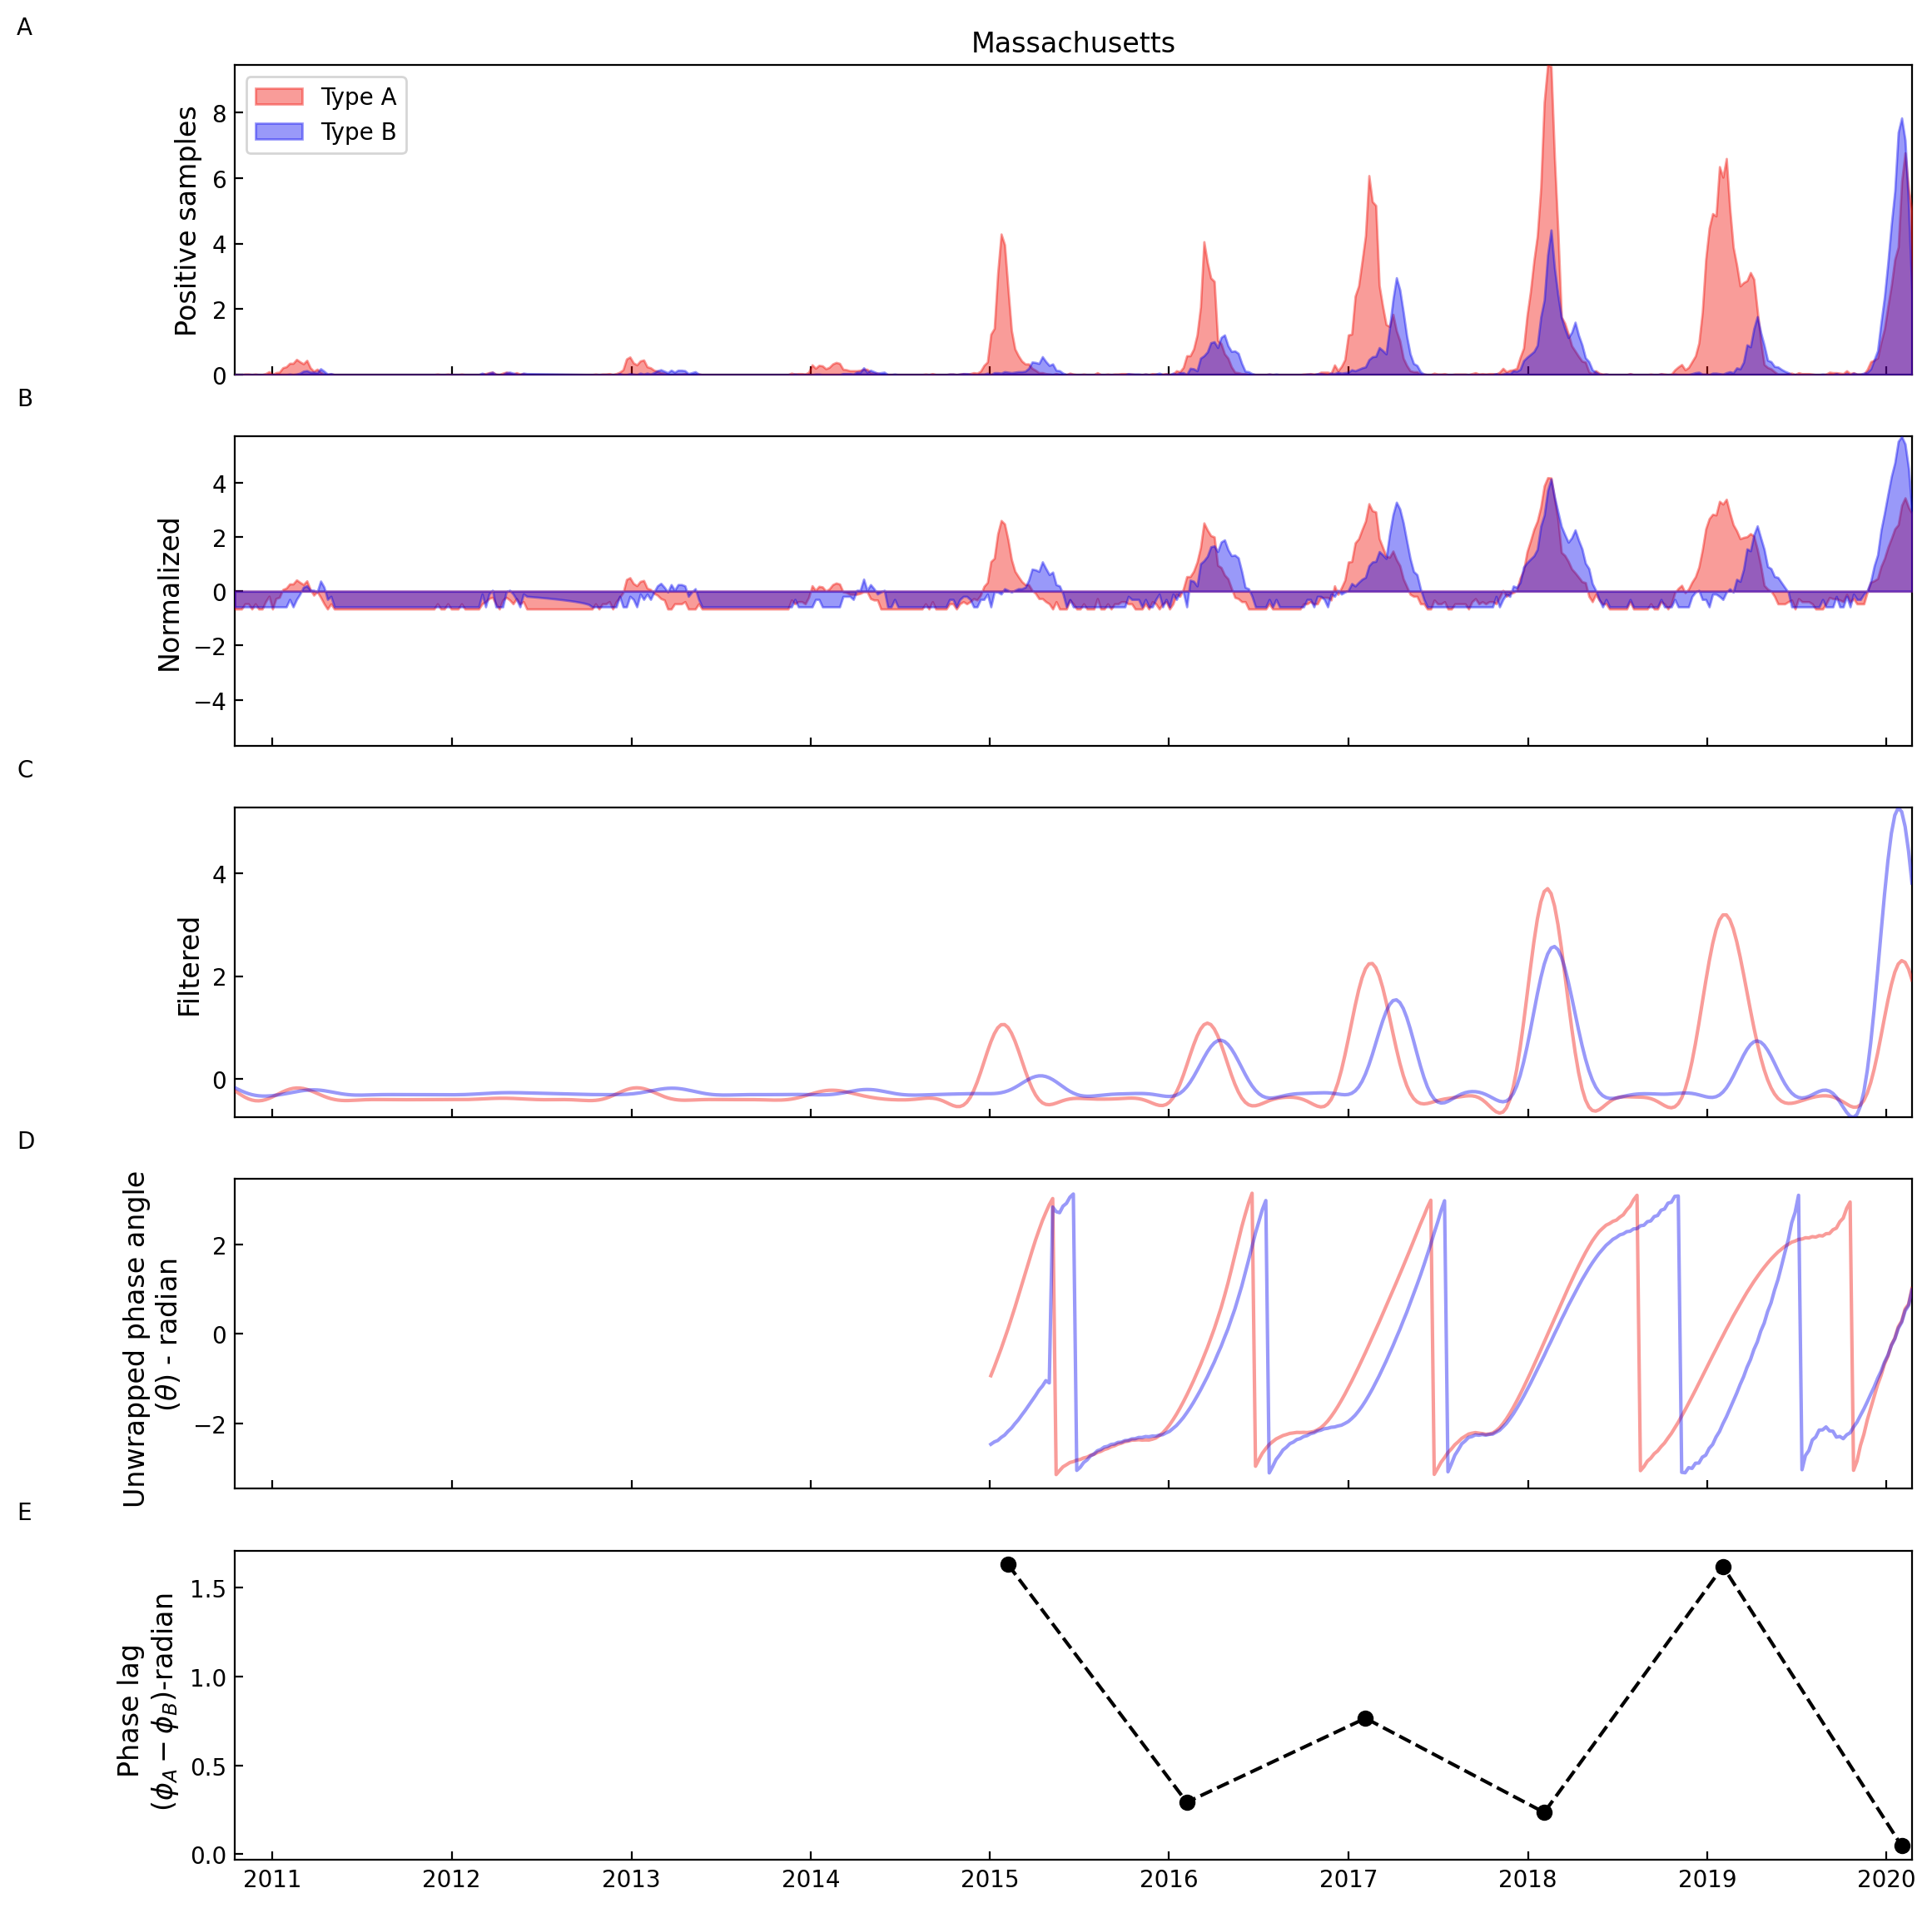

In [134]:
cmap = mpl.cm.get_cmap('jet')
fig,[ax1,ax2,ax3,ax4,ax5]=plt.subplots(5,1,figsize=(6.5*2,7*2),sharex=True)
axes = [ax1,ax2,ax3,ax4,ax5]


ax1.fill_between(df_A.index, 0,df_A[state],alpha=0.4,color=cmap(0.9),zorder=3,label='Type A')
ax1.fill_between(df_B.index, 0,df_B[state],alpha=0.4,color=cmap(0.1),zorder=3,label='Type B')
ax1.set_ylim((0,df_A[state].max()))
ax1.set_xlim((df_A.index[0],df_A.index[-1]))
ax1.legend(loc=2)
ax1.set_title(state)



ax2.fill_between(df_normalized_state.index, 0,df_normalized_state['A'],alpha=0.4,color=cmap(0.9),zorder=3,label='Type A')
ax2.fill_between(df_normalized_state.index, 0,df_normalized_state['B'],alpha=0.4,color=cmap(0.1),zorder=3,label='Type B')
ax2.set_ylim((-df_normalized_state['B'].max(),df_normalized_state['B'].max()))



ax3.plot(wave_A_wide,alpha=0.4,color=cmap(0.9),zorder=3,label='Type A')
ax3.plot(wave_B_wide,alpha=0.4,color=cmap(0.1),zorder=3,label='Type B')
ax3.set_ylim((wave_B_wide[0].min(),wave_B_wide[0].max()))



ax4.plot(df_phi_state_wrapped_wide['A']['2015':],alpha=0.4,color=cmap(0.9),zorder=3,label='Type A')
ax4.plot(df_phi_state_wrapped_wide['B']['2015':],alpha=0.4,color=cmap(0.1),zorder=3,label='Type B')
#ax3.set_ylim((-6,6))


ax5.plot(df_phase_lag_snapshots[state]['2015':],linestyle='--',marker='o',color='black')

# ax5.plot(df_phi_state_unwrapped_wide['B'].index,df_phi_state_unwrapped_wide['A']-df_phi_state_unwrapped_wide['B'],
#          linestyle='--',
#          color='black')

for i,ax in enumerate(axes):
    ax.set_ylabel(ax_labels[i],fontsize=12)
    ax.grid(False)
    ax.tick_params(axis='x',direction='in',bottom=True)
    ax.tick_params(axis='y',direction='in',left=True)
    ax.text(x=-0.13,y=1.1,s=ax_number[i],transform=ax.transAxes)

    
plt.savefig(f'./paper_output/Fig1_phase_lag_steps_{state}.pdf',dpi=300,bbox_inches='tight',pad_inche=0)
    
plt.show()

## Deriving instantaneous phase angle for fly type A and B for each state

In [166]:
t0 = time()
results_CWT_A = Parallel(n_jobs=num_cores)(delayed(Matlab_Band_Hilbert_lowpass)(df_A[state],passband=0.9) for state in df_A.columns)
t1 = time()
print(f'CWT type A took {t1 - t0} seconds')
results_CWT_B = Parallel(n_jobs=num_cores)(delayed(Matlab_Band_Hilbert_lowpass)(df_B[state],passband=0.9) for state in df_B.columns)
print(f'CWT type B took {time() - t1} seconds')

CWT type A took 45.71818280220032 seconds
CWT type B took 45.69090676307678 seconds


In [133]:
df_wave_A = pd.DataFrame(index=df_A.index)
df_wave_B = pd.DataFrame(index=df_B.index)

df_phi_A = pd.DataFrame(index=df_A.index)
df_phi_B = pd.DataFrame(index=df_B.index)

for state,result_A,result_B in zip(df_A.columns,results_CWT_A,results_CWT_B):
    df_wave_A[state] = result_A[0][0].values
    df_phi_A[state]  = result_A[2][0].values
    
    df_wave_B[state] = result_B[0][0].values
    df_phi_B[state]  = result_B[2][0].values
    

In [171]:
df_phi_A.to_pickle('../ProcessedData/PhaseAngles_0o9_1o1/Per_capita_data/lowpass_filter/df_phi_A_wrapped.pickle')
df_phi_B.to_pickle('../ProcessedData/PhaseAngles_0o9_1o1/Per_capita_data/lowpass_filter/df_phi_B_wrapped.pickle')


df_phi_A.to_csv('../ProcessedData/PhaseAngles_0o9_1o1/Per_capita_data/lowpass_filter/df_phi_A_wrapped.csv')
df_phi_B.to_csv('../ProcessedData/PhaseAngles_0o9_1o1/Per_capita_data/lowpass_filter/df_phi_B_wrapped.csv')


# Phase lag between type A and B

In [37]:
df_phase_lag = df_phi_A - df_phi_B

In [38]:
df_phase_lag_snapshots = df_phase_lag[(df_phase_lag.index.month==2) & (df_phase_lag.index.day<=7)]
df_phi_A_snapshots = df_phi_A[(df_phi_A.index.month==2) & (df_phi_A.index.day<=7)]
df_phi_B_snapshots = df_phi_B[(df_phi_B.index.month==2) & (df_phi_B.index.day<=7)]